# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

# Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

<div style="color:blue;">

#### Data Problem Definition

This task is a **supervised learning** problem, with **used car prices** serving as the target variable, and **car attributes** as features. The objective involves performing **exploratory data analysis (EDA)** and **feature engineering** to understand data distributions and relationships among features. Subsequently, **regression models** will be developed to quantify the predictive influence of each attribute on car prices. Ultimately, insights derived from **feature importance metrics** will highlight key price drivers, enabling targeted, data-driven recommendations to the dealership.

</div>


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

<div style="color:blue;">

#### Data Problem Definition

During data understanding the main steps I would want to perform are

- **Check for Missing Values**: Identify nulls (`NA`, `None`, `null`) and empty values across columns.
- **Detect Outliers**: Use the Interquartile Range (IQR) method to find extreme numeric values.
- **Checked for Inconsistent Capitalization**: Examine categorical columns to detect duplicate categories differing only in letter case (upper/lower).
- **Identify Leading/Trailing Whitespace**: Analyzed textual columns for extra whitespace that may affect consistency.
- **Understand the Unique Values**: Examine categorical columns to understand the cardinality of data.

</div>

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
df = pd.read_csv("data/vehicles.csv", low_memory=False)

<div style="color:blue;">

#### Load the data and look the info

</div>

In [20]:
df.head(300)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [21]:
#Data Analysis - Analyze the data for nulls, blanks and unknowns
def report_missing_values(df):
   
    missing_count = df.isnull().sum()

    missing_percentage = ((df.isnull().sum() / len(df)) * 100).round(1)

    unknown_count = df.apply(lambda col: col.astype(str).isin(['unknown', 'unknowns', '']).sum())

    missing_df = pd.DataFrame({
        'Column Name': missing_count.index,
        'Number of Missing Values': missing_count.values,
        'Percentage': missing_percentage.values,
        'Unknown/Blank Count': unknown_count.values
    })
    
    return missing_df

report_missing_values(df)



,Column Name,Number of Missing Values,Percentage,Unknown/Blank Count
0,id,0,0.0,0
1,region,0,0.0,0
2,price,0,0.0,0
3,year,1205,0.3,0
4,manufacturer,17646,4.1,0
5,model,5277,1.2,2
6,condition,174104,40.8,0
7,cylinders,177678,41.6,0
8,fuel,3013,0.7,0
9,odometer,4400,1.0,0


In [22]:
#Data Analysis - Analyze the data for uniqueness, outliers, casing and other forms of NA/null
import pandas as pd
import numpy as np

def report_data_quality(df):
   
    total_rows = len(df)
    alt_missing_values_list = ['NA', 'N/A', 'null', 'None']
    summary_data = []
    
    for col in df.columns:
        col_series = df[col]
        
        # Unique Values Count
        unique_values_count = col_series.nunique(dropna=True)

        # Leading/Trailing Whitespace Count: for object columns only
        if col_series.dtype == 'object':
            lt_whitespace_count = col_series.dropna().astype(str).apply(lambda x: x != x.strip()).sum()
        else:
            lt_whitespace_count = np.nan
        
        # Numeric Outlier Count: use IQR method for numeric columns
        if pd.api.types.is_numeric_dtype(col_series):
            q1 = col_series.quantile(0.25)
            q3 = col_series.quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            numeric_outliers_count = col_series[(col_series < lower_bound) | (col_series > upper_bound)].count()
        else:
            numeric_outliers_count = np.nan
        
        # Inconsistent Data Types: list unique types in non-missing values.
        types = col_series.dropna().apply(lambda x: type(x).__name__).unique()
        if len(types) > 1:
            inconsistent_types = ", ".join(sorted(types))
        else:
            inconsistent_types = ""
        
        # Inconsistent Categories: for object columns, compare unique counts before and after lowercasing.
        if col_series.dtype == 'object':
            series_str = col_series.dropna().astype(str)
            original_unique = series_str.nunique()
            lower_unique = series_str.str.lower().nunique()
            if lower_unique < original_unique:
                inconsistent_categories = f"Yes (Original: {original_unique}, Lowercase: {lower_unique})"
            else:
                inconsistent_categories = "No"
        else:
            inconsistent_categories = np.nan
        
        summary_data.append({
            'Column Name': col,
            'Unique Values Count': unique_values_count,
            'Leading/Trailing Whitespace Count': lt_whitespace_count,
            'Numeric Outlier Count': numeric_outliers_count,
            'Inconsistent Data Types': inconsistent_types,
            'Inconsistent Categories': inconsistent_categories
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df.index.name = 'Index'
    return summary_df


report_data_quality(df)


,Column Name,Unique Values Count,Leading/Trailing Whitespace Count,Numeric Outlier Count,Inconsistent Data Types,Inconsistent Categories
Index,,,,,,
0,id,426880,NaN,44.0,,NaN
1,region,404,0.0,NaN,,No
2,price,15655,NaN,8177.0,,NaN
3,year,114,NaN,15896.0,,NaN
4,manufacturer,42,0.0,NaN,,No
5,model,29649,0.0,NaN,,"Yes (Original: 29649, Lowercase: 28558)"
6,condition,6,0.0,NaN,,No
7,cylinders,8,0.0,NaN,,No
8,fuel,5,0.0,NaN,,No


# **Data Analysis Summary**

### <span style='color:blue'>**Dataset Overview (Complete Dataset)**</span>

- **Total rows:** 426,880
- **Total columns:** 18
- **Columns and Data Types:**
  - **Numeric Columns:** 
    - id (int64)
    - price (int64)
    - year (float64)
    - odometer (float64)
  - **Categorical/Object Columns:**
    - region, manufacturer, model, condition, cylinders, fuel, title_status, transmission, VIN, drive, size, type, paint_color, state
---

### <span style='color:blue'>**Missing Data Analysis**</span>

- Columns with high percentages of missing values:
  - **size:** 71.8% missing values
  - **cylinders:** 41.6% missing values
  - **condition:** 40.8% missing values
  - **VIN:** 37.7% missing values
  - **type:** 21.8% missing values
  - **paint_color:** 30.5% missing values

- **Columns with no missing data:** id, region, price, state

---

### <span style='color:blue'>**Unique Values and Outliers Analysis**</span>

- **High Unique Counts:**
  - **id:** 426,880 unique values
  - **model:** 29,649 unique values, inconsistency in formatting (case sensitivity)
  - **VIN:** 118,246 unique values
  - **odometer:** 104,870 unique values
  - **region:** 404 unique values

- **Significant Numeric Outliers:**
  - **year:** 15,896 numeric outliers
  - **price:** 8,177 numeric outliers
  - **odometer:** 4,385 numeric outliers

- **Consistency Checks:**
  - **No inconsistencies** detected in categories for columns: region, condition, fuel, title_status, transmission, drive, size, type, paint_color

---  



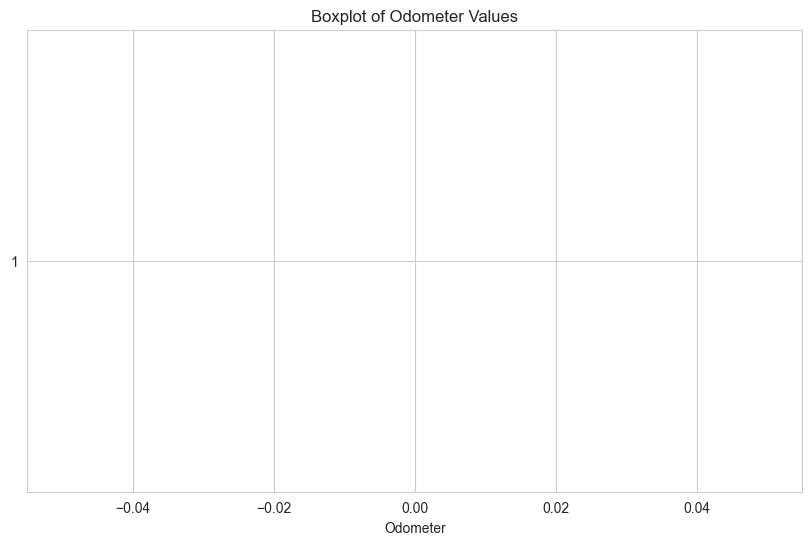

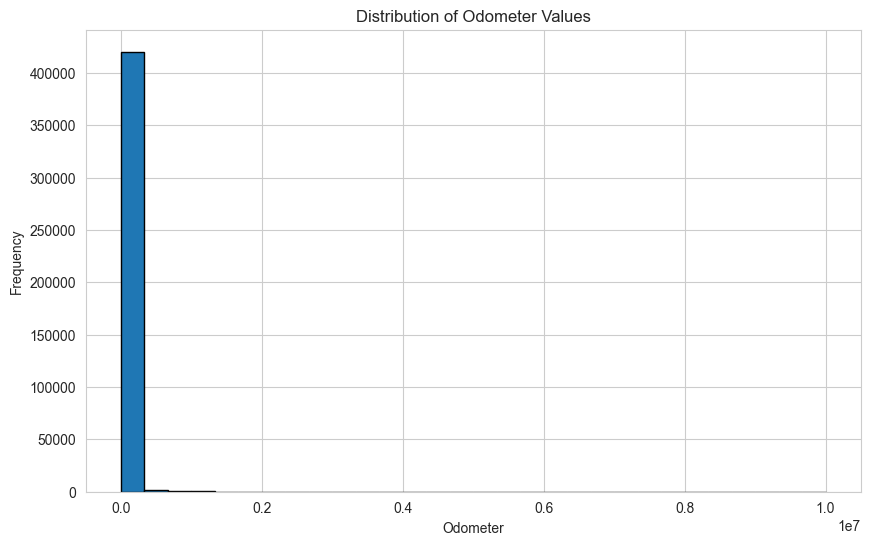

In [23]:
# Create a boxplot to visualize the distribution and identify outliers for odometer values
plt.figure(figsize=(10, 6))
plt.boxplot(df["odometer"], vert=False)
plt.xlabel("Odometer")
plt.title("Boxplot of Odometer Values")
plt.show()

# Create a histogram to see the overall distribution of the odometer values
plt.figure(figsize=(10, 6))
plt.hist(df["odometer"], bins=30, edgecolor='black')
plt.xlabel("Odometer")
plt.ylabel("Frequency")
plt.title("Distribution of Odometer Values")
plt.show()

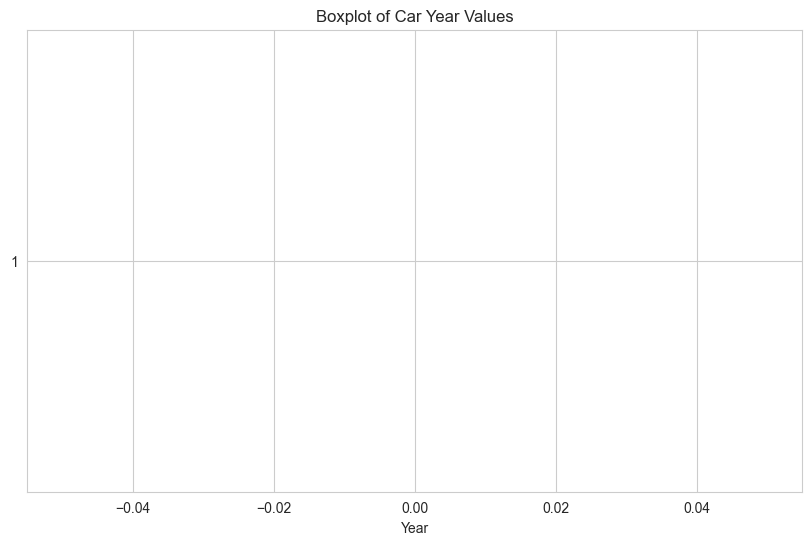

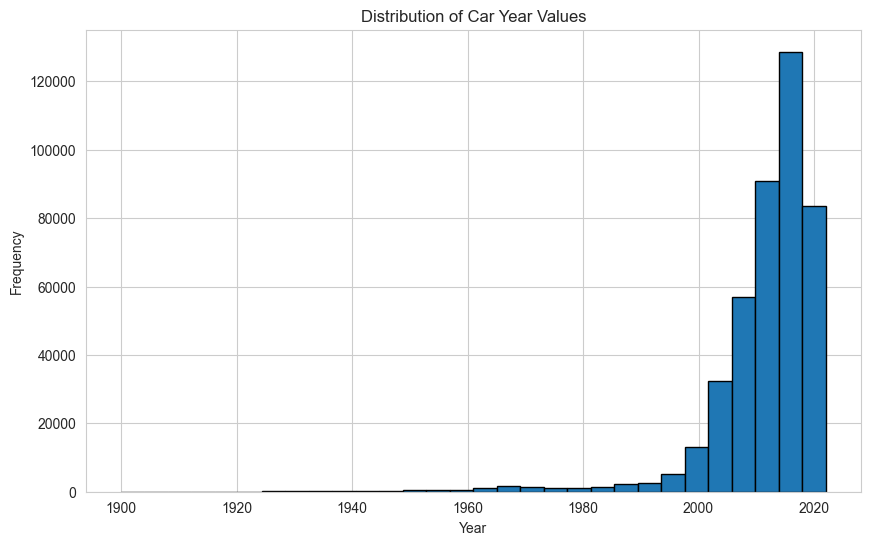

In [24]:
import matplotlib.pyplot as plt

# Print the unique year values
#print("Unique year values:", df["year"].unique())

# Create a boxplot to visualize the distribution and identify outliers
plt.figure(figsize=(10, 6))
plt.boxplot(df["year"], vert=False)
plt.xlabel("Year")
plt.title("Boxplot of Car Year Values")
plt.show()

# Create a histogram to see the overall distribution of the years
plt.figure(figsize=(10, 6))
plt.hist(df["year"], bins=30, edgecolor='black')
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.title("Distribution of Car Year Values")
plt.show()


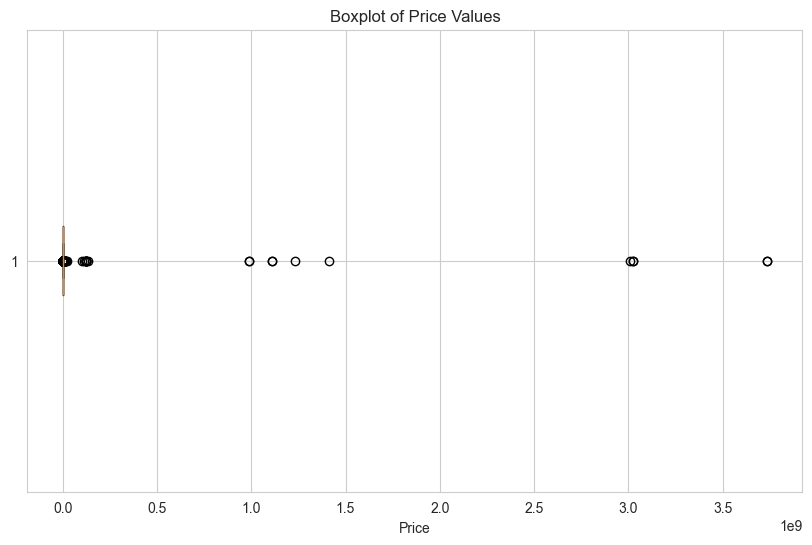

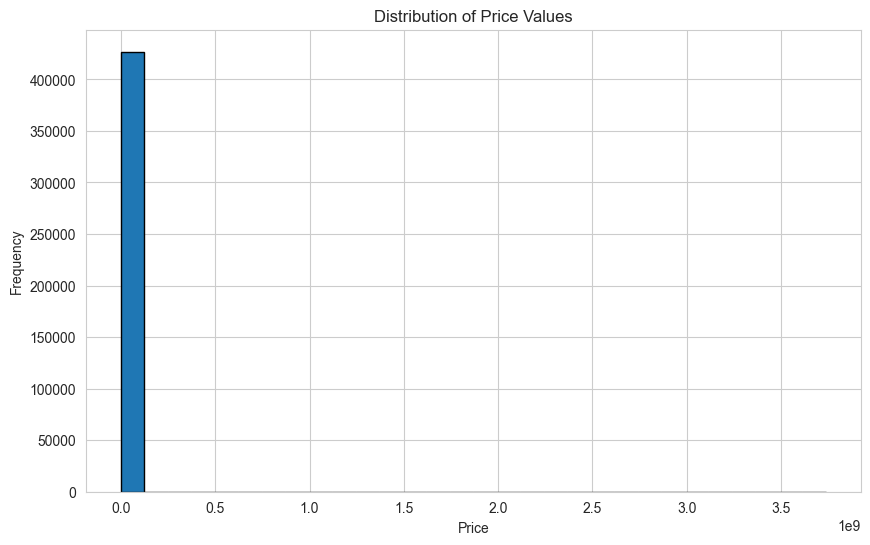

In [26]:
import matplotlib.pyplot as plt

# Create a boxplot to visualize the distribution and identify outliers for price values
plt.figure(figsize=(10, 6))
plt.boxplot(df["price"], vert=False)
plt.xlabel("Price")
plt.title("Boxplot of Price Values")
plt.show()

# Create a histogram to see the overall distribution of the price values
plt.figure(figsize=(10, 6))
plt.hist(df["price"], bins=30, edgecolor='black')
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Distribution of Price Values")
plt.show()

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

<span style='color:blue'>**Step 1: Drop Columns (High Cardinality or Low Value)**</span>

In [27]:
# Drop columns with very high cardinality or that are unique identifiers
columns_to_drop = ['id', 'VIN', 'model', 'region','state']
df = df.drop(columns=columns_to_drop, errors='ignore')

<span style='color:blue'>**Step 2: Handle Missing Data (Row-Level Deletion)**</span>

In [28]:
df = df.dropna(subset=['year', 'price'])

<span style='color:blue'>**Step 3: Outlier Treatment**</span>

In [29]:
# Price outlier removal using quantile thresholds
price_lower = 0.0
price_upper = 100000
print(price_lower)
print(price_upper)
df = df[(df['price'] >= price_lower) & (df['price'] <= price_upper)]

# Odometer outlier removal
odometer_upper = 200000
df = df[df['odometer'] <= odometer_upper]
print(odometer_upper)

# Year outlier removal
year_lower = 1995
year_upper = 2021
df = df[(df['year'] >= year_lower) & (df['year'] <= price_upper)]

0.0
100000
200000


<span style='color:blue'>**Step 4: Impute Numeric Columns (Median)**</span>

In [30]:
df['odometer'] = df['odometer'].fillna(df['odometer'].median())

<span style='color:blue'>**Step 5: Impute Categorical Columns (Mode)**</span>

In [50]:
categorical_cols_mode = ['manufacturer', 'fuel', 'transmission', 'type', 
                         'title_status', 'condition', 'cylinders', 'drive', 
                         'paint_color', 'size']

for col in categorical_cols_mode:
    df[col] = df[col].fillna(df[col].mode()[0])

KeyError: 'manufacturer'

<span style='color:blue'>**Step 6: Feature Engineering (Categorize Manufacturers as they have high cardinality)**</span>

In [52]:
luxury = ['ferrari', 'land rover', 'aston-martin', 'tesla', 'porsche', 'bmw', 'mercedes-benz', 'audi', 'alfa-romeo']
economy = ['ford', 'chevrolet', 'toyota', 'honda', 'nissan', 'hyundai', 'kia','fiat', 'subaru']
specialty = ['harley-davidson', 'mini']

def categorize_manufacturer(manufacturer):
    if manufacturer in luxury:
        return 'Luxury'
    elif manufacturer in economy:
        return 'Economy'
    elif manufacturer in specialty:
        return 'Specialty'
    else:
        return 'Other'

df['manufacturer_group'] = df['manufacturer'].apply(categorize_manufacturer)


KeyError: 'manufacturer'

<span style='color:blue'>**Step 6.1: Drop Manufacturer once we have manufacturer group**</span>

In [ ]:
df = df.drop(columns='manufacturer', errors='ignore')

<span style='color:blue'>**Step 7: Feature Engineering (Scale Odometer)**</span>


In [53]:
# Rescale the 'odometer' column to thousands of miles
df['odometer'] = df['odometer'] / 1000

<span style='color:blue'>**Step 8: Relook at the cleaned up data**</span>

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 383093 entries, 27 to 426879
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               383093 non-null  int64  
 1   year                383093 non-null  float64
 2   condition           383093 non-null  object 
 3   cylinders           383093 non-null  object 
 4   fuel                383093 non-null  object 
 5   odometer            383093 non-null  float64
 6   title_status        383093 non-null  object 
 7   transmission        383093 non-null  object 
 8   drive               383093 non-null  object 
 9   size                383093 non-null  object 
 10  type                383093 non-null  object 
 11  paint_color         383093 non-null  object 
 12  manufacturer_group  383093 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 40.9+ MB


<span style='color:blue'>**Step 8.1: Look at the overall data quality**</span>


In [37]:
report_data_quality(df)

,Column Name,Unique Values Count,Leading/Trailing Whitespace Count,Numeric Outlier Count,Inconsistent Data Types,Inconsistent Categories
Index,,,,,,
0,price,14984,NaN,6750.0,,NaN
1,year,28,NaN,6983.0,,NaN
2,condition,6,0.0,NaN,,No
3,cylinders,8,0.0,NaN,,No
4,fuel,5,0.0,NaN,,No
5,odometer,95407,NaN,0.0,,NaN
6,title_status,6,0.0,NaN,,No
7,transmission,3,0.0,NaN,,No
8,drive,3,0.0,NaN,,No


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 383093 entries, 27 to 426879
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               383093 non-null  int64  
 1   year                383093 non-null  float64
 2   condition           383093 non-null  object 
 3   cylinders           383093 non-null  object 
 4   fuel                383093 non-null  object 
 5   odometer            383093 non-null  float64
 6   title_status        383093 non-null  object 
 7   transmission        383093 non-null  object 
 8   drive               383093 non-null  object 
 9   size                383093 non-null  object 
 10  type                383093 non-null  object 
 11  paint_color         383093 non-null  object 
 12  manufacturer_group  383093 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 40.9+ MB


In [39]:
report_missing_values(df)

,Column Name,Number of Missing Values,Percentage,Unknown/Blank Count
0,price,0,0.0,0
1,year,0,0.0,0
2,condition,0,0.0,0
3,cylinders,0,0.0,0
4,fuel,0,0.0,0
5,odometer,0,0.0,0
6,title_status,0,0.0,0
7,transmission,0,0.0,0
8,drive,0,0.0,0
9,size,0,0.0,0


<span style='color:blue'>**Step 8.2: Visualize the cleaned up data**</span>


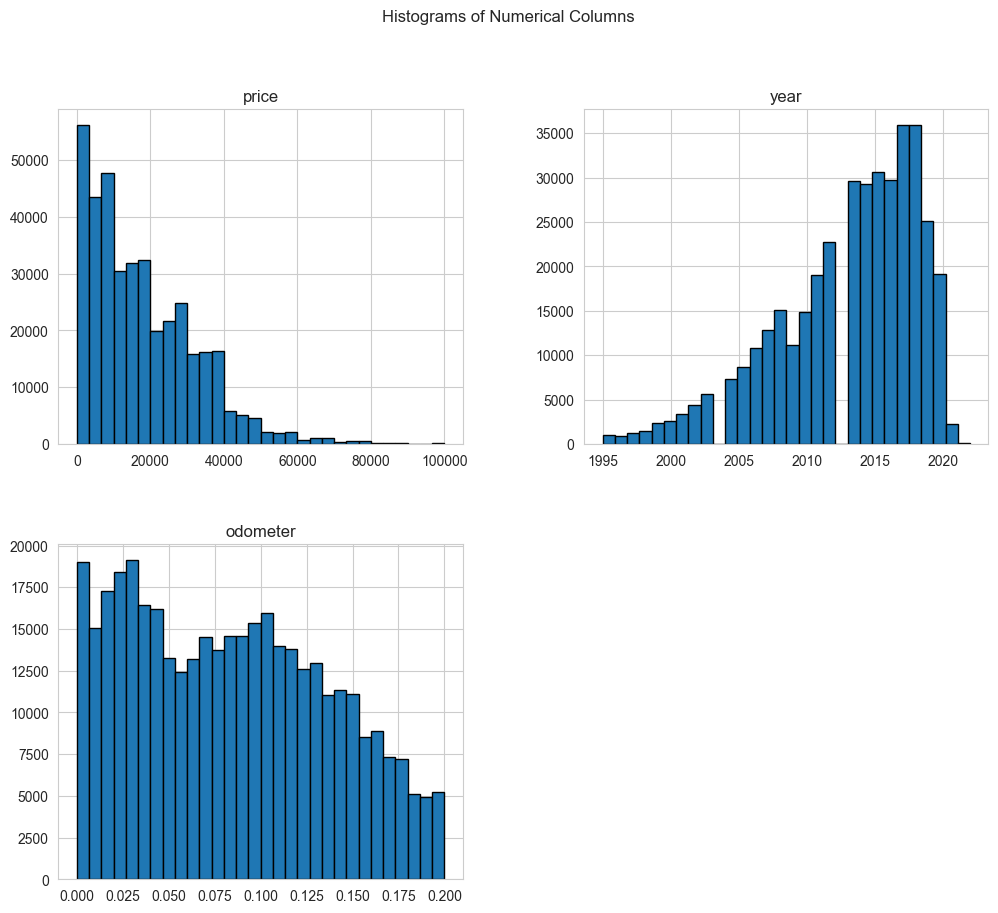

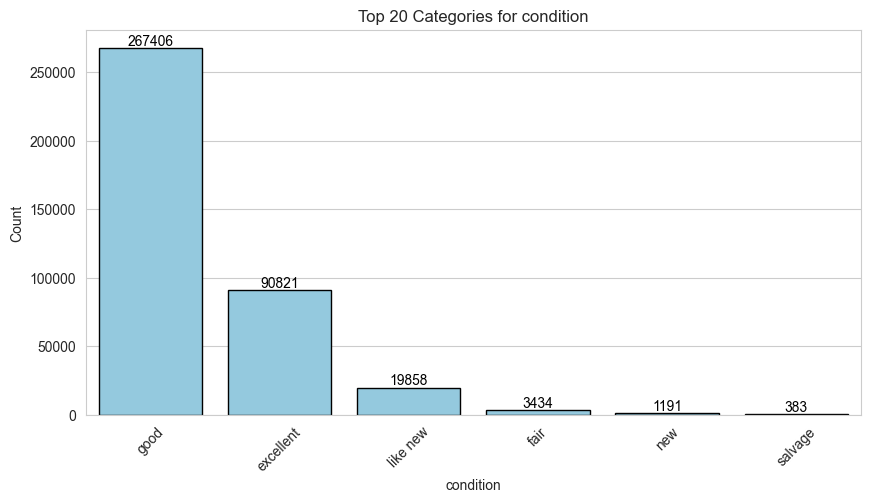

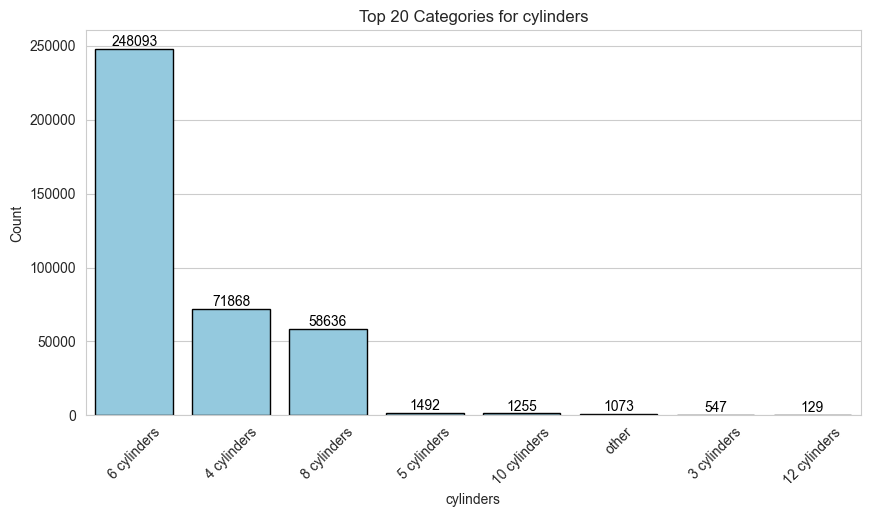

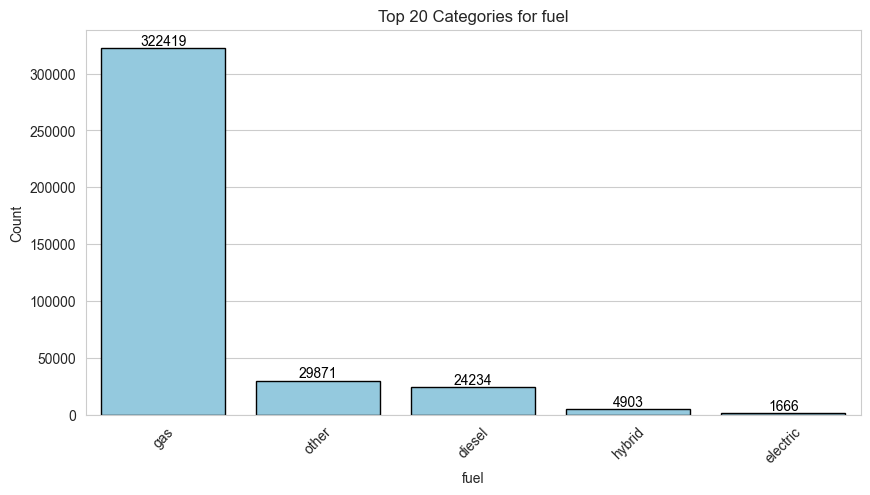

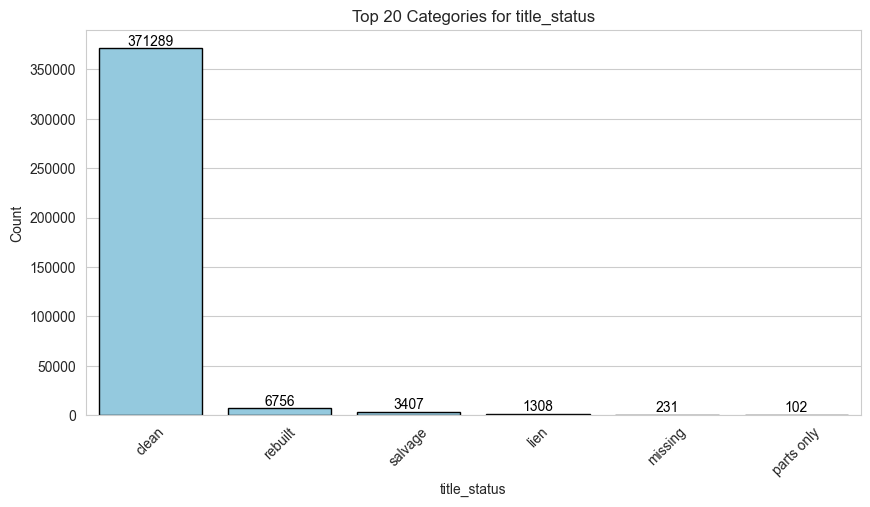

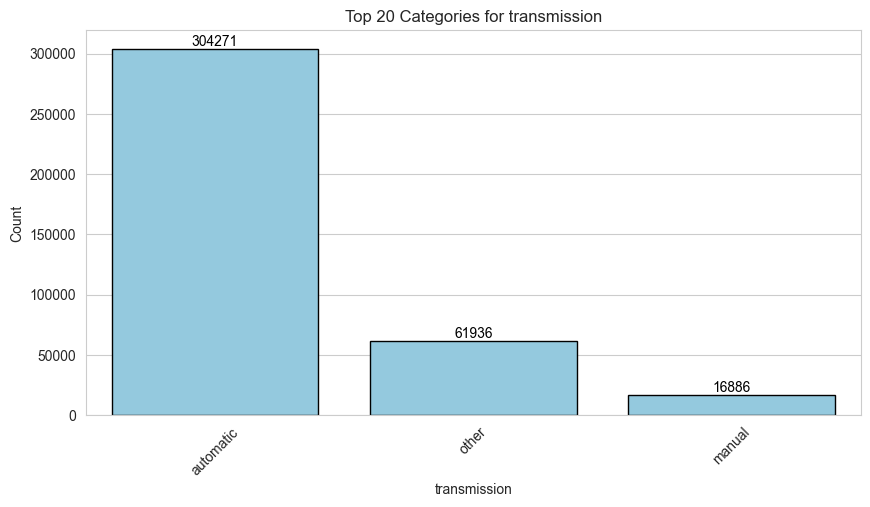

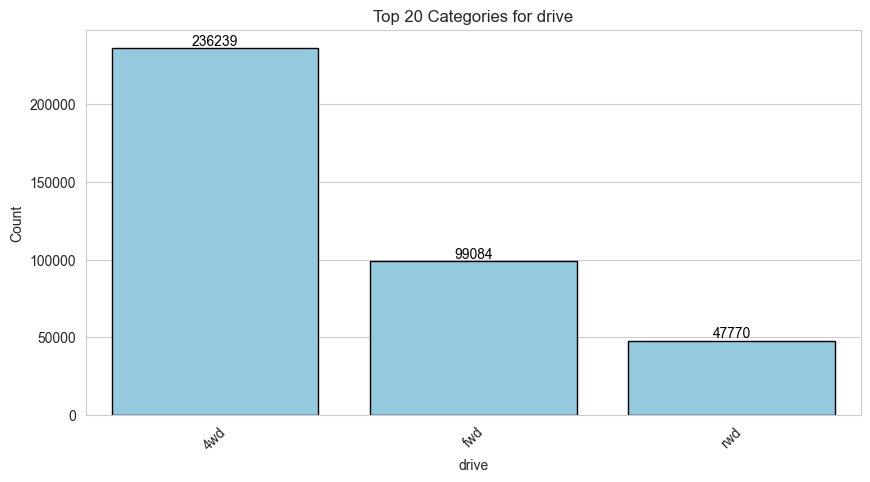

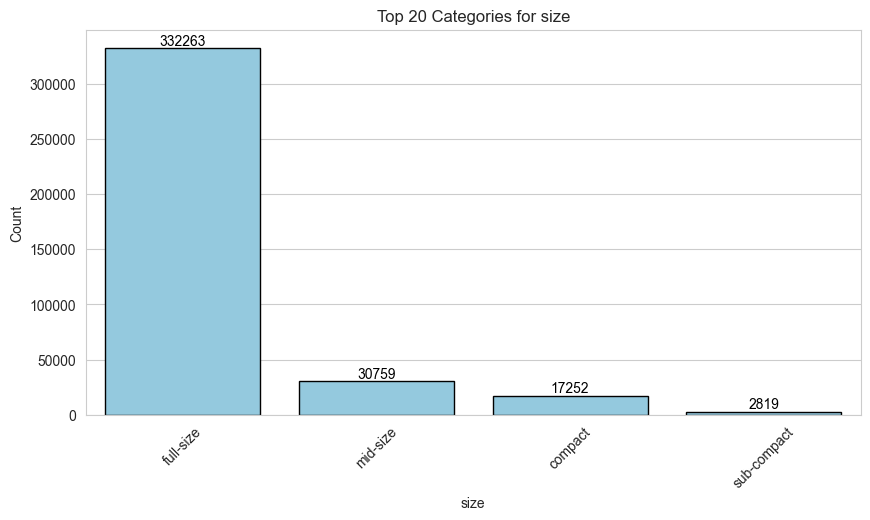

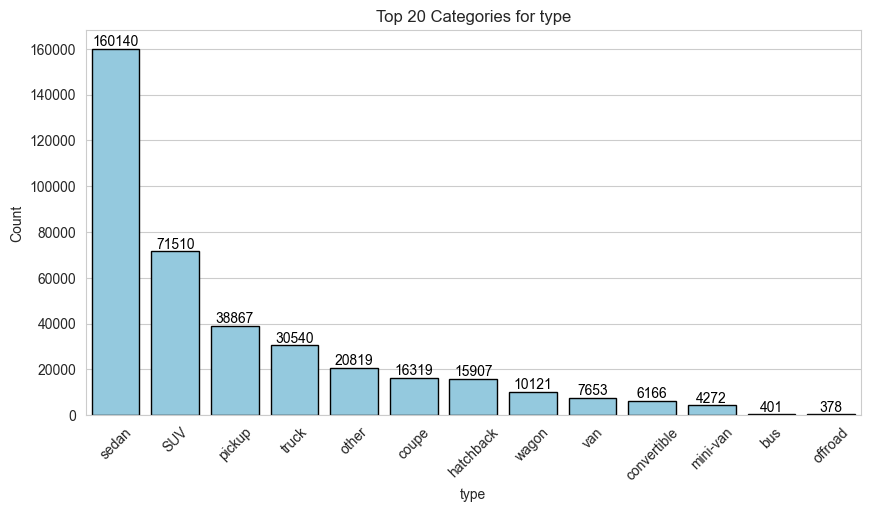

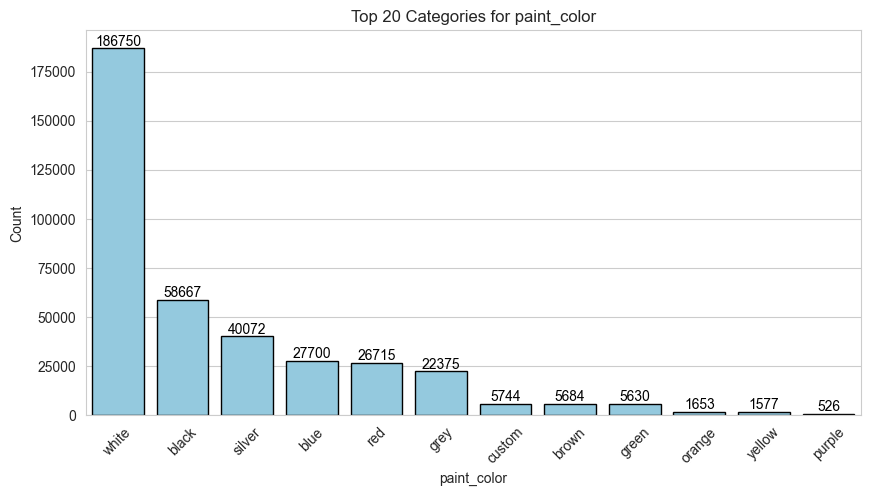

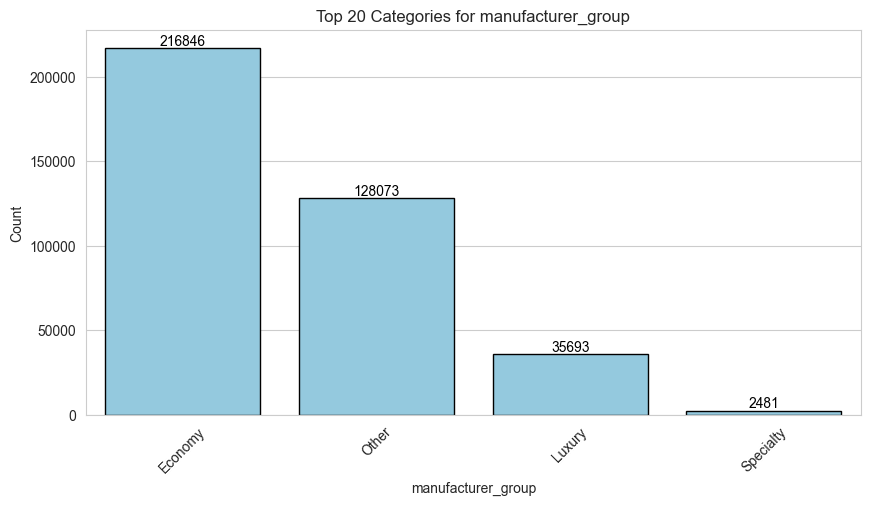

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the cleaned-up data
# Identify numerical and categorical columns
numerical_columns = df.select_dtypes(include=['number']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Plot histograms for numerical columns
df[numerical_columns].hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.suptitle("Histograms of Numerical Columns")
plt.show()

# Plot bar charts for categorical columns (top 10 categories for each)
for col in categorical_columns:
    plt.figure(figsize=(10, 5))
    
    # Create the bar plot using seaborn
    value_counts = df[col].value_counts().head(20)
    ax = sns.barplot(x=value_counts.index, y=value_counts.values, color='skyblue', edgecolor="black")
    
    # Add the count labels on top of the bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    fontsize=10, color='black', 
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords='offset points')
    
    plt.title(f"Top 20 Categories for {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability
    plt.show()


# **Data Analysis After Clean up**

### <span style='color:blue'>**Dataset Overview (Complete Dataset)**</span>

- **Total rows:** 383093 (from 426K)
- **Total columns:** 12 (from 18)
- **No unknowns, blanks and reduced outliers in the data**
- **Other aspects:** 
    - The data looks cleaner but there are segments like 12 cylinder which are few in number and indicating a rare categories which could impact the car trends
    - We have removed some categories like manufacturer and made a grouping of manufacturer group to get a better sense of impact, however some times a specific manufacturer could also have impact on trend.
---


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

<span style='color:blue'>**Start Analysis with a generic regression model**</span>

In [55]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop('price', axis=1)
y = df['price']

# Convert categorical features to numeric (one-hot encoding)
X = pd.get_dummies(X, drop_first=True)

# Optional: split data into train/test (here we use training data for feature impact)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Create a DataFrame of features and their coefficients
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr.coef_
})

# Sort features by the magnitude of impact (absolute value of coefficient)
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)

print("Feature impact on price (positive means increase, negative means decrease):")
coef_df[['Feature', 'Coefficient']]

Feature impact on price (positive means increase, negative means decrease):


,Feature,Coefficient
1,odometer,-58109.1
7,cylinders_12 cylinders,14174.4
15,fuel_gas,-12593.2
17,fuel_other,-11238.0
16,fuel_hybrid,-10890.7
14,fuel_electric,-9083.5
20,title_status_parts only,-8841.3
8,cylinders_3 cylinders,-8415.7
13,cylinders_other,-7035.2
37,type_pickup,6349.3


### <span style='color:blue'> This data with coefficients shows some weird aspects like gas which is the most common type of car having a lower price. Also fuel being in the top 5 makes we think there is some segmentation by feul type here as 'cylinders' is only applicable for 'gas' cars. Now trying with Ridge regression model to get a better idea on which features have a real impact.  </span>


In [59]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import pandas as pd

# Separate features and target
X = df.drop('price', axis=1)  # Assuming 'price' is the target
y = df['price']

# Convert categorical features to numeric (one-hot encoding)
X = pd.get_dummies(X, drop_first=True)

# Optional: split data into train/test (using training data for feature impact)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Ridge regression model with a regularization strength (alpha)
ridge = Ridge(alpha=2.0)  # You can adjust the alpha value to control regularization strength

# Fit the model
ridge.fit(X_train, y_train)

# Get the coefficients and their feature names
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': ridge.coef_
})

# Sort by absolute value of the coefficients to see the most impactful features
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

print("Feature impact on price (positive means increase, negative means decrease):")
coef_df[['Feature', 'Coefficient']]


Feature impact on price (positive means increase, negative means decrease):


,Feature,Coefficient
7,cylinders_12 cylinders,13929.5
37,type_pickup,6349.8
35,type_offroad,5941.5
31,type_convertible,4180.7
18,title_status_lien,3089.0
39,type_truck,2949.2
53,manufacturer_group_Luxury,2806.1
24,transmission_other,2232.2
32,type_coupe,2220.5
23,transmission_manual,1916.5


### <span style='color:blue'> After seeing the results from Ridge also there is not much of a difference in the co-efficients which indicates that the impact of Cyliners, Type of Vehicle, Fuel Type, Odometer are very much impacting the final price of the vehicle. However since some of the aspects like cyliners only make sense for gas , separating out feul types would help me provide a better recommendation to the car dealer</span>

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [62]:
import pandas as pd
import statsmodels.formula.api as smf

models = {}
for fuel in df['fuel'].unique():
    df_fuel = df[df['fuel'] == fuel]
    formula = 'price ~ odometer + year + condition + type + manufacturer_group + paint_color + title_status + cylinders + transmission + drive + size'
    model = smf.ols(formula, data=df_fuel).fit()
    models[fuel] = model
    print(f"___________________________________")
    print(f"___________________________________")
    print(f"Model summary for fuel type: {fuel}")
    print(model.summary())
    file_location = "/Users/ms/Downloads/coef_summary" + fuel + ".txt"
    with open(file_location, 'w') as f:
        f.write(model.summary().as_text())  


___________________________________
___________________________________
Model summary for fuel type: gas
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     5179.
Date:                Sat, 29 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:47:49   Log-Likelihood:            -3.4217e+06
No. Observations:              322419   AIC:                         6.844e+06
Df Residuals:                  322366   BIC:                         6.844e+06
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-----

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

# Final Summary: What Consumers Value in a Used Car

This recommendation to car dealer is based on regression analyses across fuel types — gas, diesel, electric, hybrid, and other — and identifies features that significantly impact the resale price of used vehicles.

---

## 1. Condition of the Vehicle
- Vehicles in **"like new"** or **"good"** condition consistently command **higher prices**.
- **"Fair"** or **"salvage"** condition leads to significant **price drops**, especially in diesel and gas vehicles.
- Electric and hybrid models also show positive pricing effects for better condition.

---

## 2. Vehicle Type
- **Pickup trucks** and **convertibles** generally sell for **higher prices** across most fuel types.
- **Hatchbacks**, **mini-vans**, and **wagons** typically result in **lower resale values** (strongest in gas, hybrid, and other categories).
- **Offroad** and **truck** types (especially in gas and diesel) have **positive price influence**.

---

## 3. Manufacturer Group
- **Luxury brands** are strongly associated with **higher prices** across **all fuel types**, with the largest positive coefficients found in electric and hybrid cars.
- Vehicles from **“Other” manufacturers** also add value, particularly in hybrids and gas types.
- **Diesel vehicles** showed a **negative impact** for luxury brands, possibly due to lower market demand.

---

## 4. Transmission & Drive
- **“Other” transmission types** often result in **higher prices** (especially in electric and hybrid).
- **Manual transmission** has a **positive impact in hybrids** but is neutral or negative in others.
- **Front-wheel drive (FWD)** is associated with **lower prices** across all segments.
- **Rear-wheel drive (RWD)** generally adds value, especially in diesel and other types.

---

## 5. Cylinders (Non-Electric Only)
- **Gas and diesel vehicles** with **6 or 8 cylinders** often have **higher prices**.
- **Electric vehicles do not have cylinders**, and this variable is not relevant for them.
- In hybrids and other types, cylinder count has mixed or minimal effects on price.

---

## 6. Year and Odometer
- **Newer vehicles** strongly increase resale price across **all fuel types**.
- **Lower mileage (odometer)** is correlated with **higher price**, especially in **gas, diesel, and other** types.
- The effect is strongest in hybrid and diesel vehicles.

---

## 7. Paint Color
- **Red** and **yellow** sometimes increase value (e.g., electric and hybrid), though inconsistently.
- **Blue, white, silver, orange, and custom colors** generally reduce resale price.
- **Green and purple** tend to lower prices, especially in gas, diesel, and other fuel types.

---

## Conclusion
To meet consumer demand and maximize value:
- Focus on **newer, well-maintained vehicles**, especially from **luxury manufacturers**.
- Avoid **high-mileage**, **salvage-title**, or **low-demand body types**.
- Tailor purchases by fuel type, noting that electric cars prioritize **brand, year, and tech**, not traditional features like cylinders.
